# Let's Group Sessions From the Camera Roll based on Timestamp

## Instructions

First, you will need to move `my-photos-creationdate.txt` to a directory where `jupyter` can access it.

In [5]:
filename = '../my-photos-creationdate.txt'

with open(filename, 'r') as file:
    create_timestamps_file = file.read()

In [6]:
create_timestamps_file = create_timestamps_file.replace('[Composite]     SubSecCreateDate                : ', '')

In [7]:
_lines = create_timestamps_file.split('\n')
len(_lines)

15018

In [24]:
# filter empty
_lines = [l for l in _lines if l != '']

In [8]:
from datetime import datetime, timedelta

In [25]:
def exif2datetime(_exifdt):
    _date, _time = _exifdt.split(' ')
    _date = _date.replace(':', '-')
    return datetime.fromisoformat(' '.join([_date, _time]))

In [26]:
dts_all = [exif2datetime(_exifdt) for _exifdt in _lines]

In [27]:
dts_all.sort()

TypeError: can't compare offset-naive and offset-aware datetimes

Surprise, not all timestamps have timezones, for some reason. So let's just pretend there is no timezone.

In [28]:
dts_all_no_tz = [_dt.replace(tzinfo=None) for _dt in dts_all]

In [29]:
dts_all_no_tz.sort()

In [30]:
dts_all_no_tz[1] - dts_all_no_tz[0]

datetime.timedelta(days=967, seconds=15171, microseconds=673000)

In [31]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Photo Count Per Day')

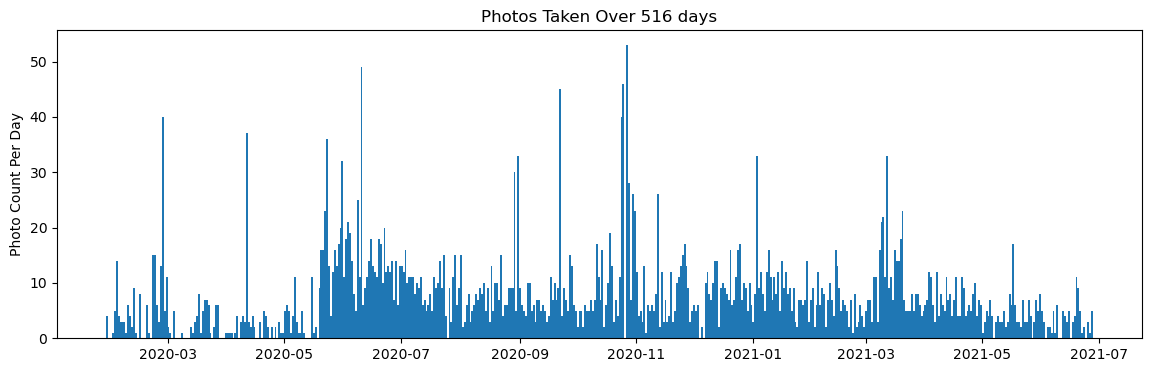

In [32]:
dts_subset = dts_all_no_tz[1:4000]
_span = dts_subset[-1] - dts_subset[0]

bins = np.arange(dts_subset[0], dts_subset[-1], timedelta(days = 1))

plt.figure(figsize=(14,4))
_ =plt.hist(dts_subset,bins=bins)

plt.title(f'Photos Taken Over {str(_span).split(',')[:-1][0]}')
plt.ylabel('Photo Count Per Day')

## Photos Per Day

In [40]:
day_first = dts_all_no_tz[1]
day_last = dts_all_no_tz[-1]
print(day_first)
print(day_last)
# print(day_first + timedelta(days=1))

2020-01-28 19:35:47.673000
2025-01-20 00:02:45.265000
2020-01-29 19:35:47.673000


In [47]:
photos_per_day = [0]
dts_index = 0
current_day = day_first

while dts_index < len(dts_all_no_tz):
    if dts_all_no_tz[dts_index] - current_day >= timedelta(days=1):
        # new day
        current_day += timedelta(days=1)
        photos_per_day.append(0)
    #counting
    photos_per_day[-1] = photos_per_day[-1] + 1
    
    dts_index += 1

(1.0, 107.0)

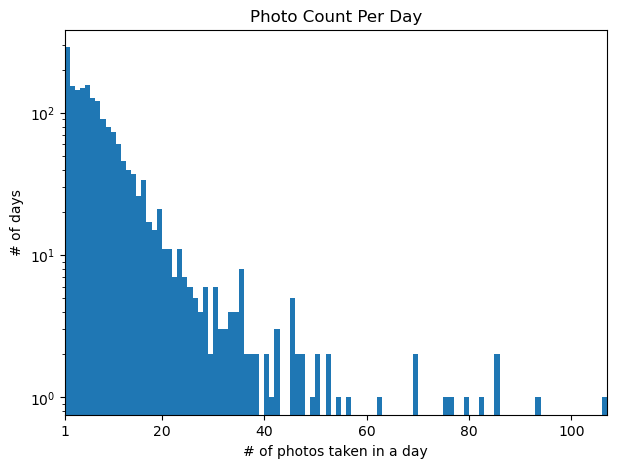

In [82]:
sidebysidefigsize = (7, 5)

plt.figure(figsize=sidebysidefigsize)
plt.yscale('log')
bins = range(1, max(photos_per_day) + 1)
_ = plt.hist(photos_per_day, bins=bins)
plt.title('Photo Count Per Day')
plt.ylabel('# of days')
plt.xlabel('# of photos taken in a day')

locs, labels = plt.xticks()
locs = np.insert(locs, 1, 1)
labels =np.insert(labels, 1, 1)
_ = plt.xticks(locs, labels)
plt.xlim(1, max(bins))


## Group Into Sessions

Based on neighbours within a time window

In [75]:
dts_deltas = [0]
for i in range(len(dts_all_no_tz)):
    dts_deltas.append(dts_all_no_tz[i] - dts_all_no_tz[i-1])

In [79]:
def _hist_sessions(_session_photo_counts, merge_under_delta):

    bins = range(1, max(_session_photo_counts) + 1)

    plt.figure(figsize=sidebysidefigsize)
    plt.yscale('log')
    _ = plt.hist(_session_photo_counts, bins=bins)
    plt.title('Sessions with a Given Number of Photos' + f'\n (same session if within {merge_under_delta})')
    plt.xlabel('Photo Count in a Session')
    plt.ylabel('# of Sessions Found')

    locs, labels = plt.xticks()
    locs = np.insert(locs, 1, 1)
    labels =np.insert(labels, 1, 1)
    _ = plt.xticks(locs, labels)
    plt.xlim(1, max(bins))

def session_finding(dts_deltas, merge_under_delta = timedelta(seconds = 40)):
    _sessions_by_index = [[]]
    _delta_index = 0
    
    while _delta_index < len(dts_deltas) - 1:
        _sessions_by_index[-1].append(_delta_index)
        
        if dts_deltas[_delta_index + 1] > merge_under_delta:
            # next photo will be a new session
            _sessions_by_index.append([])
            
        _delta_index += 1
    
    _session_photo_counts = [len(sesh) for sesh in _sessions_by_index]
    #np.unique(_session_photo_counts)

    _hist_sessions(_session_photo_counts, merge_under_delta)

    return _sessions_by_index, _session_photo_counts


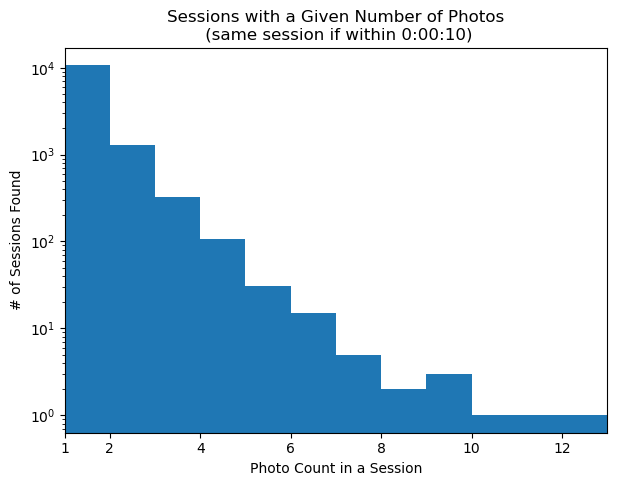

In [80]:
_ = session_finding(dts_deltas, merge_under_delta=timedelta(seconds=10))

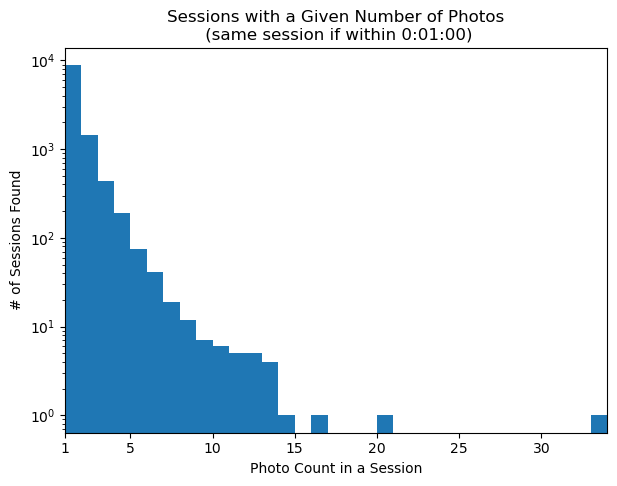

In [81]:
_ = session_finding(dts_deltas, merge_under_delta=timedelta(seconds=60))